### Understanding vanishing and exploding gradient problem using different activation functions
- Difference in loss function behavior when we use RelU vs Sigmoid function
- Using gradient tape to analyze gardients 

In [1]:
import numpy as np
from sklearn.datasets import make_blobs
from keras.utils import to_categorical
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import utils as ut
import pandas as pd

In [2]:
trainX, trainy, testX, testy = ut.create_dataset(n_samples=1000, centers=20, n_features=100, cluster_std=2, random_state=2)
n_input, n_classes = trainX.shape[1], testy.shape[1]

In [3]:
def evaluate_model(n_layers, trainX, trainy, testX, testy, activation):
    model = tf.keras.Sequential()
    model.add(layers.Dense(10, activation=activation, name='layer-0', input_shape=(n_input,)))
    for i in range(n_layers):
        model.add(layers.Dense(10, activation=activation, name='layer-'+str(i+1), input_shape=(n_input,)))            
    model.add(layers.Dense(n_classes, activation='softmax', name='layer-'+str(i+2)))
        
    model.compile(optimizer='sgd', loss = 'categorical_crossentropy', metrics=['accuracy'])
    history = model.fit(trainX, trainy, epochs=100, verbose=0)  
    loss_val, test_acc = model.evaluate(testX, testy, verbose=0)
    
    return history, test_acc, model

### Explation of code:

**model.compile**:
- optimizer: the algorithm used to update weights during training. e.g., adam, sgd
- a loss function: to measure the error between the predicted value and the actual value, 
    - Categorical_crossentropy: true labels are one-hot encoded
- metrics: list of metrics to be evaluated by model during testing and training
- run_eagerly: 

**model.fit**:
Returns a history object. Its History.histoyr attribute is a record of training loss values and metrics values at succesive epochs, as well as validation loss values and validation metrics values (if applicable)

**model.evaluate**
returns scalar test loss or a list of scalars 

### Sigmoid activation function

2023-07-19 09:42:50.587438: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


nodes=1: 0.374
nodes=2: 0.084
nodes=3: 0.038
nodes=4: 0.038
nodes=5: 0.038
nodes=10: 0.038


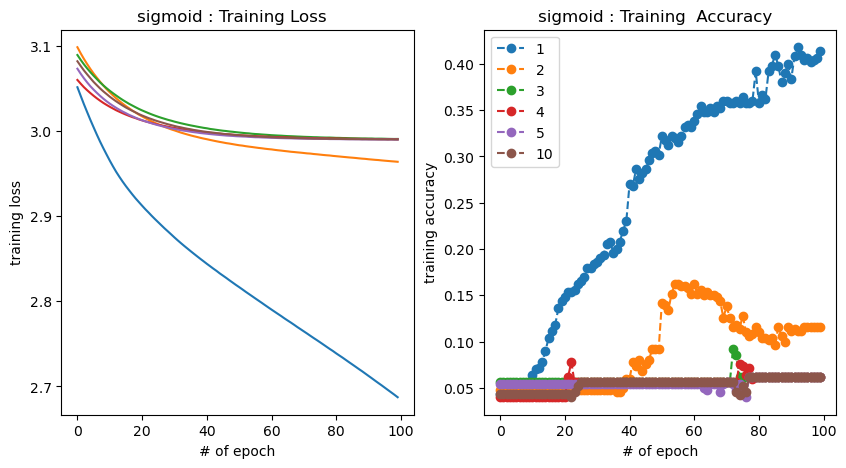

In [4]:
num_layers = [1,2,3,4,5,10]
plt.figure(figsize=(10,5))
activation = 'sigmoid'
for n_layers in num_layers:
  history, result, model = evaluate_model(n_layers, trainX, trainy, testX, testy, activation)
  # summarize final test set accuracy
  print('nodes=%d: %.3f' % (n_layers, result))

  # plot learning curve 
  plt.subplot(1,2,1)
  plt.plot(history.history['loss'], label=str(n_layers))
  plt.xlabel('# of epoch')
  plt.ylabel('training loss')
  plt.title(activation + ' : Training Loss  ')

  plt.subplot(1,2,2)
  plt.plot(history.history['accuracy'], label=str(n_layers), marker = 'o', linestyle='--')
  plt.xlabel('# of epoch')
  plt.ylabel('training accuracy')
  plt.title(activation + ' : Training  Accuracy  ')


plt.legend()
plt.show()

**Observation:**
- Loss function does not change/flattens for very deep layers with sigmoid function

#### Relu activation function

nodes=1: 1.000
nodes=2: 0.994
nodes=3: 0.992
nodes=4: 0.992
nodes=5: 0.972
nodes=10: 0.098


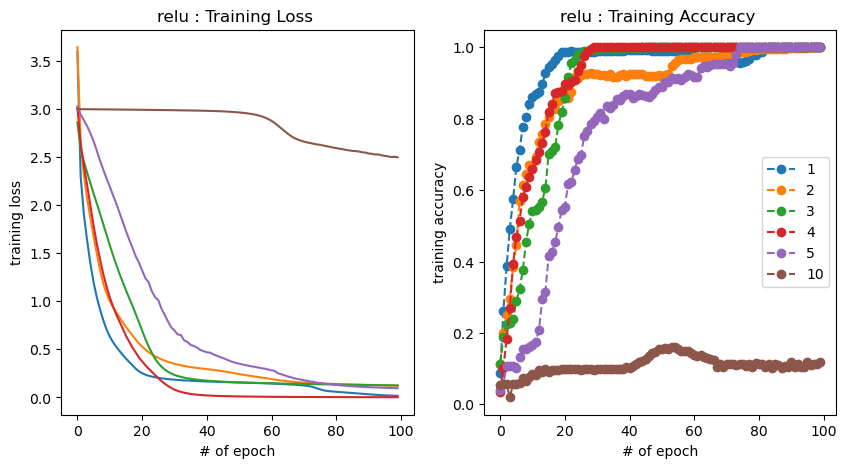

In [5]:
num_layers = [1,2,3,4,5,10]
plt.figure(figsize=(10,5))
activation = 'relu'
for n_layers in num_layers:
  history, result, model = evaluate_model(n_layers, trainX, trainy, testX, testy, activation)
  # summarize final test set accuracy
  print('nodes=%d: %.3f' % (n_layers, result))

  # plot learning curve 
  plt.subplot(1,2,1)
  plt.plot(history.history['loss'], label=str(n_layers))
  plt.xlabel('# of epoch')
  plt.ylabel('training loss')
  plt.title(activation + ' : Training Loss ')

  plt.subplot(1,2,2)
  plt.plot(history.history['accuracy'], label=str(n_layers), marker = 'o', linestyle='--')
  plt.xlabel('# of epoch')
  plt.ylabel('training accuracy')
  plt.title(activation + ' : Training Accuracy ')

plt.legend()
plt.show()

### Plotting gradients during back propagation

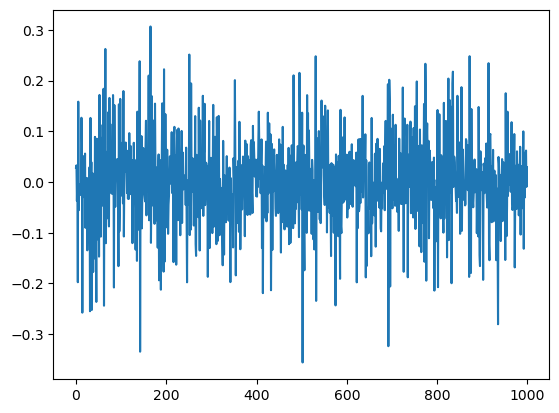

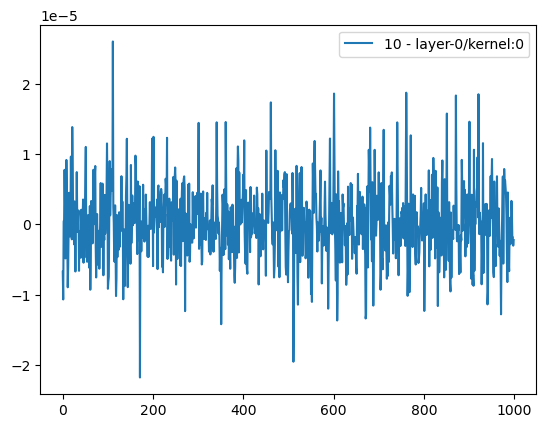

In [6]:
num_layers = [3,10]

activation = 'sigmoid'
for n_layers in num_layers:
  history, result, model = evaluate_model(n_layers, trainX, trainy, testX, testy, activation)
  with tf.GradientTape() as tape:
      pred = model(trainX)
      loss = tf.keras.losses.categorical_crossentropy(trainy, pred)
      grads = tape.gradient(loss, model.trainable_variables)

  # plot learning curve
  plt.figure()
  for var, g in zip(model.trainable_variables, grads):
      #print(f'{var.name}, shape: {g.shape}')    
      if 'layer-0/kernel' in var.name:
          plt.plot(g.numpy().flatten(), label=str(n_layers) +' - ' + str(var.name))
        
plt.legend()
plt.show()



**Observations:**
- Sigmoid function: Gradients of weights for layer-0 goes to 1e-5 when network is deep (10 layers).
- We do not see this behavior of weights in layer 9/10
- This does not happen for relu activation function even when network is deep.